# Imported Data and loaded dataset

In [669]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams

from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import recall_score, accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV,\
cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import StackingRegressor
from sklearn.impute import SimpleImputer

from mpl_toolkits import mplot3d

In [336]:
pd.set_option('display.max_columns', None)
X = pd.read_csv('../../../data/trainingsetvalues.csv')
y = pd.read_csv('../../../data/trainingsetlabels.csv')

In [337]:
df = pd.concat((X,y), axis = 1)
df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,id,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,69572,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,8776,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,34310,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,67743,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,19728,functional


# Replaced Null Values and dropped columns

In [338]:
X.funder = X.funder.replace(np.nan, 'Unknown')
X.installer = X.installer.replace(np.nan, 'Unknown')
X.permit = X.permit.replace(np.nan, False)

In [339]:
y = y.drop(columns = 'id')

In [340]:
y.status_group.loc[y.status_group == 'functional'] = 1
y.status_group.loc[y.status_group != 1] = 0
y = y.astype(int)

In [342]:
droplist = ['wpt_name', 'subvillage', 'num_private', 'scheme_name', 'recorded_by', 'scheme_management', 'management', 'extraction_type', 
            'payment', 'extraction_type_class', 'quality_group', 'quantity_group', 'source', 'source_class', 'waterpoint_type_group', 'ward',
           'region_code', 'district_code', 'public_meeting', 'funder', 'lga', 'management_group']

X_clean = X.drop(columns = droplist, axis=1)

# Created a new age column

In [343]:
years = [int(X_clean['date_recorded'][x][:4]) for x in range(len(X_clean['date_recorded']))]
X_clean['date_recorded'] = years

In [344]:
X_clean.construction_year = X_clean.construction_year.replace(0, 2000)

In [345]:
X_clean['age'] = X_clean['date_recorded'] - X_clean['construction_year']

# Cleaned up the Installer Column

In [346]:
top_installers = list(X_clean.installer.value_counts()[:7].index)
top_installers

['DWE', 'Unknown', 'Government', 'RWE', 'Commu', 'DANIDA', 'KKKT']

In [347]:
X_clean.installer.loc[~X_clean['installer'].isin(top_installers)] = 'Other'

/Applications/Utilities/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


# Filled in Zero's for the gps_height column

In [348]:
dodoma_idx = X_clean[X_clean.region == 'Dodoma'].index
X_clean.at[dodoma_idx, 'gps_height'] = 1350

In [349]:
kagera_idx = X_clean[X_clean.region == 'Kagera'].index
X_clean.at[kagera_idx, 'gps_height'] = 1450

In [350]:
mbeya_idx = X_clean[X_clean.region == 'Mbeya'].index
X_clean.at[mbeya_idx, 'gps_height'] = 1715

In [351]:
tabora_idx = X_clean[X_clean.region == 'Tabora'].index
X_clean.at[tabora_idx, 'gps_height'] = 1200

In [352]:
shinyanga_idx = X_clean[X_clean.region == 'Shinyanga'].index
X_clean.at[shinyanga_idx, 'gps_height'] = 1162

In [353]:
mwanza_idx = X_clean[X_clean.region == 'Mwanza'].index
X_clean.at[mwanza_idx, 'gps_height'] = 1200

# Made a function for returning catagorical and numerical columns

In [355]:
def cleaning(data):
    cat_cols = list(data.select_dtypes('object'))
    numeric_cols = list(data.select_dtypes('number'))
    cat_df = pd.DataFrame(data[cat_cols])
    numeric_df = pd.DataFrame(data[numeric_cols])
    return cat_df, numeric_df

# Train Test Split

In [356]:
X_train_raw, X_val_raw, y_train, y_val = train_test_split(X_clean, y, random_state = 1)

# Split into categorical and numerical

In [357]:
train_cats, train_nums = cleaning(X_train_raw)
val_cats, val_nums = cleaning(X_val_raw)
train_nums.drop(columns = ['longitude', 'latitude', 'id'], inplace=True)
val_nums.drop(columns = ['longitude', 'latitude', 'id'], inplace=True)

# One hot encoder and scaler

In [358]:
ohe = OneHotEncoder(sparse=False)
ohe.fit(train_cats)
train_cats_ohe = pd.DataFrame(ohe.transform(train_cats), columns = ohe.get_feature_names(input_features = train_cats.columns))
val_cats_ohe = pd.DataFrame(ohe.transform(val_cats), columns = ohe.get_feature_names(input_features = val_cats.columns))

In [359]:
ss = StandardScaler()
ss.fit(train_nums)
train_nums_scaled = pd.DataFrame(ss.transform(train_nums), columns = train_nums.columns)
val_nums_scaled = pd.DataFrame(ss.transform(val_nums), columns = val_nums.columns)

In [360]:
X_train = pd.concat((train_nums_scaled, train_cats_ohe), axis=1)
X_val = pd.concat((val_nums_scaled, val_cats_ohe), axis=1)

# Function for testing models

In [858]:
def modeling_function(model, X_train, y_train, X_val, y_val):

    # fit model on training data
    y_train = np.array(y_train).ravel()
    y_val = np.array(y_val).ravel()

    model.fit(X_train, y_train)

    # make predictions on training and validation data
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val)

    # Print accuracy score
    
    train_acc = accuracy_score(y_train, train_preds).round(3)
    val_acc = accuracy_score(y_val, val_preds).round(3)
    train_f1 = f1_score(y_train, train_preds).round(3)
    val_f1 = f1_score(y_val, val_preds).round(3)
    
    print('----------------------------------------------------')
    print('Accuracy Score:')
    print('Training score: ', accuracy_score(y_train, train_preds).round(3))
    print('Validation score: ', accuracy_score(y_val, val_preds).round(3))
    print('----------------------------------------------------')
    
    print('----------------------------------------------------')
    print('f1 Score:')
    print('Training score: ', f1_score(y_train, train_preds).round(3))
    print('Validation score: ', f1_score(y_val, val_preds).round(3))
    print('----------------------------------------------------')
    
    print('\nConfusion Matrix:')
    print(confusion_matrix(y_val, val_preds))
    
    # return fitted model
    return model
    return train_acc
    return val_acc
    return train_f1
    return val_f1

# First Log Model

In [859]:
log_model1 = LogisticRegression(random_state=1, max_iter = 350)
modeling_function(log_model1, X_train, y_train, X_val, y_val)

----------------------------------------------------
Accuracy Score:
Training score:  0.752
Validation score:  0.748
----------------------------------------------------
----------------------------------------------------
f1 Score:
Training score:  0.79
Validation score:  0.788
----------------------------------------------------

Confusion Matrix:
[[4141 2653]
 [1095 6961]]


LogisticRegression(max_iter=350, random_state=1)

# Second Log Model (tuned)

In [874]:
log_model2 = LogisticRegression(random_state = 1, penalty = 'l1', solver = 'liblinear', max_iter = 350, class_weight = 'balanced')
modeling_function(log_model2, X_train, y_train, X_val, y_val)

----------------------------------------------------
Accuracy Score:
Training score:  0.749
Validation score:  0.743
----------------------------------------------------
----------------------------------------------------
f1 Score:
Training score:  0.782
Validation score:  0.777
----------------------------------------------------

Confusion Matrix:
[[4400 2394]
 [1416 6640]]


LogisticRegression(class_weight='balanced', max_iter=350, penalty='l1',
                   random_state=1, solver='liblinear')

# First Tree Model

In [529]:
dt_1 = DecisionTreeClassifier()
modeling_function(dt_1, X_train, y_train, X_val, y_val)

----------------------------------------------------
Accuracy Score:
Training score:  0.943
Validation score:  0.771
----------------------------------------------------
----------------------------------------------------
f1 Score:
Training score:  0.948
Validation score:  0.792
----------------------------------------------------

Confusion Matrix:
[[4999 1795]
 [1602 6454]]


DecisionTreeClassifier()

# Second Tree Model (Tuned)

In [531]:
dt_2 = DecisionTreeClassifier(random_state = 1, criterion = 'entropy', max_depth = 10)
modeling_function(dt_2, X_train, y_train, X_val, y_val)

----------------------------------------------------
Accuracy Score:
Training score:  0.765
Validation score:  0.751
----------------------------------------------------
----------------------------------------------------
f1 Score:
Training score:  0.809
Validation score:  0.797
----------------------------------------------------

Confusion Matrix:
[[3886 2908]
 [ 790 7266]]


DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=1)

# Third Tree Model (GridSearch)

In [532]:
dt_3 = DecisionTreeClassifier()
param_grid = {
    'criterion':['entropy', 'gini'],
    'max_depth':[3, 5, 10, None],
    'min_samples_split':[2, 5, 8],
    'max_features': [10, 15, 20, None]
}

In [533]:
gs_tree = GridSearchCV(dt_3, param_grid, scoring='f1')
gs_tree.fit(X_train, np.array(y_train).ravel())

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [3, 5, 10, None],
                         'max_features': [10, 15, 20, None],
                         'min_samples_split': [2, 5, 8]},
             scoring='f1')

In [534]:
gs_tree_best = gs_tree.best_estimator_

In [535]:
gs_tree_train_preds = gs_tree_best.predict(X_train)
gs_tree_val_preds = gs_tree_best.predict(X_val)

# Print accuracy score

print('----------------------------------------------------')
print('Accuracy Score:')
print('Training score: ', accuracy_score(y_train, gs_tree_train_preds).round(3))
print('Validation score: ', accuracy_score(y_val, gs_tree_val_preds).round(3))
print('----------------------------------------------------')

print('----------------------------------------------------')
print('f1 Score:')
print('Training score: ', f1_score(y_train, gs_tree_train_preds).round(3))
print('Validation score: ', f1_score(y_val, gs_tree_val_preds).round(3))
print('----------------------------------------------------')

print('\nConfusion Matrix:')
print(confusion_matrix(y_val, gs_tree_val_preds))

----------------------------------------------------
Accuracy Score:
Training score:  0.764
Validation score:  0.751
----------------------------------------------------
----------------------------------------------------
f1 Score:
Training score:  0.808
Validation score:  0.798
----------------------------------------------------

Confusion Matrix:
[[3888 2906]
 [ 785 7271]]


# First Random Forest Model

In [536]:
rf_1 = RandomForestClassifier()
modeling_function(rf_1, X_train, y_train, X_val, y_val)

----------------------------------------------------
Accuracy Score:
Training score:  0.943
Validation score:  0.805
----------------------------------------------------
----------------------------------------------------
f1 Score:
Training score:  0.949
Validation score:  0.827
----------------------------------------------------

Confusion Matrix:
[[5064 1730]
 [1161 6895]]


RandomForestClassifier()

# Second Random Forest Model (Tuned)

In [550]:
rf_2 = RandomForestClassifier(max_depth = 18, min_samples_split = 15, n_estimators = 50)
modeling_function(rf_2, X_train, y_train, X_val, y_val)

----------------------------------------------------
Accuracy Score:
Training score:  0.842
Validation score:  0.806
----------------------------------------------------
----------------------------------------------------
f1 Score:
Training score:  0.865
Validation score:  0.836
----------------------------------------------------

Confusion Matrix:
[[4655 2139]
 [ 739 7317]]


RandomForestClassifier(max_depth=18, min_samples_split=15, n_estimators=50)

# First XG Boost

In [552]:
xgb_1 = XGBClassifier(use_label_encoder=False)
modeling_function(xgb_1, X_train, y_train, X_val, y_val)

[11:09:11] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
----------------------------------------------------
Accuracy Score:
Training score:  0.829
Validation score:  0.798
----------------------------------------------------
----------------------------------------------------
f1 Score:
Training score:  0.852
Validation score:  0.826
----------------------------------------------------

Confusion Matrix:
[[4746 2048]
 [ 952 7104]]


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

# Second XG Boost (tuned)

In [586]:
xgb_1 = XGBClassifier(max_depth = 8, alpha=.5, gamma =.5, tree_method='hist')
modeling_function(xgb_1, X_train, y_train, X_val, y_val)

[11:28:10] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
----------------------------------------------------
Accuracy Score:
Training score:  0.861
Validation score:  0.806
----------------------------------------------------
----------------------------------------------------
f1 Score:
Training score:  0.878
Validation score:  0.831
----------------------------------------------------

Confusion Matrix:
[[4910 1884]
 [ 994 7062]]


XGBClassifier(alpha=0.5, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0.5, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='hist', validate_parameters=1, verbosity=None)

In [938]:
score_df = pd.DataFrame(np.array([0.79, 0.782, 0.948, 0.809, 0.808, 0.949, 0.865, 0.852, 0.878, 0.949, 0.705, 0.845]), columns = ['train_scores'])
list_of_val_scores = [ 0.788, 0.777, 0.792, 0.797, 0.798, 0.827, 0.836, 0.826, 0.831, 0.825, 0.709, 0.807]
list_of_models = ['Base Log','Tuned Log', 'Base Tree', 'Tuned Tree', 'GS Tree', 'Base Forest', 
                 'Tuned Forest', 'Base XGB', 'Tuned XGB', 'Base Bagging', 'Base NB', 'Base SV']

In [939]:
score_df['val_scores'] = list_of_val_scores
score_df['models'] = list_of_models
score_df = pd.concat((score_df, score_df), axis=0)

In [940]:
score_df['score'] = [0.79, 0.782, 0.948, 0.809, 0.808, 0.949, 0.865, 0.852, 0.878, 0.949, 0.705, 0.845,  0.788, 0.777, 0.792, 0.797, 0.798, 0.827, 0.836, 0.826, 0.831, 0.825, 0.709, 0.807]
score_df = score_df.drop(['train_scores', 'val_scores'], axis=1).reset_index()

In [951]:
types = ['train'] *12 + ['val']*12
score_df['types'] = types
score_df

,index,models,score,types
0,0,Base Log,0.790,train
1,1,Tuned Log,0.782,train
2,2,Base Tree,0.948,train
3,3,Tuned Tree,0.809,train
4,4,GS Tree,0.808,train
5,5,Base Forest,0.949,train
6,6,Tuned Forest,0.865,train
7,7,Base XGB,0.852,train
8,8,Tuned XGB,0.878,train
9,9,Base Bagging,0.949,train


(0.6, 1.0)

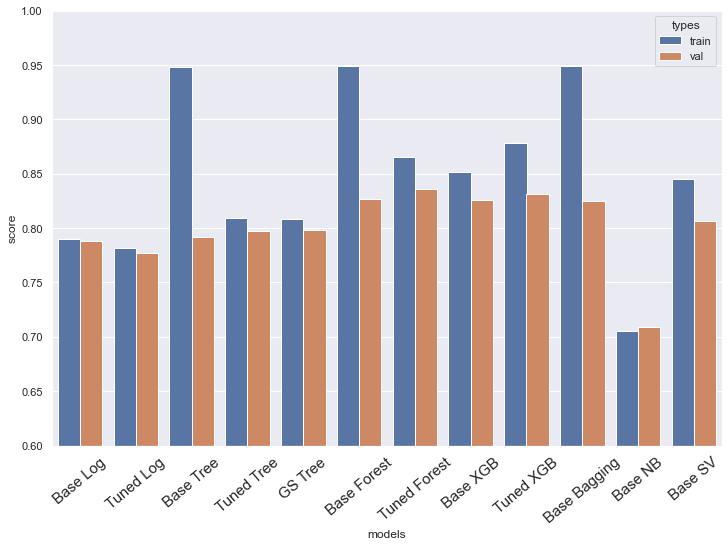

In [967]:
fig, ax = plt.subplots(figsize = (12,8))

sns.barplot(data = score_df, x = 'models', y = 'score', hue = 'types');

ax.set_xticklabels(list_of_models)
ax.tick_params(axis='x', labelsize = 15, labelrotation=40)
plt.ylim(.6, 1)